🎯 1️⃣ Conv2D는 뭘 하는 레이어야?

👉 이미지에서 "특징(feature)"를 찾아주는 레이어야!

이미지는 그냥 숫자 배열이야 (픽셀 값 0~255)
→ 근데 컴퓨터는 "이게 숫자 5냐? 7이냐?" 그냥 숫자만 봐서는 못 알아봐.

그래서 Conv2D 가 하는 일은:

✅ 필터(커널)를 이용해서 → 사진을 훑으면서 → 패턴(선, 모서리, 점, 곡선, 텍스처)을 찾아내는 것!

Conv2D(32, kernel_size=(3, 3), padding='same')

→ 3x3 크기의 필터 32개를 이미지에 적용해서 → 32개의 특징 맵(feature map)을 만든다!

✅ Conv2D → 특징 뽑아!

✅ Pooling → 크기 줄여! (중요한 것만 남겨!)

✅ Conv2D → 더 깊은 특징 뽑아!

✅ Pooling → 다시 크기 줄여!

✅ Flatten → 이제 완전 연결층(Dense)에 넘겨줄 준비 완료!


In [ ]:
# 필요한 패키지 불러오기
from keras.datasets import mnist
# from keras.utils import np_utils # This import is no longer valid in newer Keras/TensorFlow versions

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
# In newer TensorFlow/Keras, use tf.keras.utils or tf.one_hot instead of keras.utils.np_utils
from tensorflow.keras.utils import to_categorical

| 라이브러리      | 설정된 seed 값 |
| ---------- | ---------- |
| numpy      | `0`        |
| tensorflow | `3`        |

🎲 2️⃣ 왜 필요한가?
랜덤(random) 은 프로그램 실행할 때마다 결과가 달라질 수 있어.
근데 실험(예: 딥러닝 모델 학습) 을 할 때는:

✅ "똑같은 결과가 나오게 하고 싶을 때" → reproducibility (재현성)

👉 그래서 seed 값을 고정하면,
👉 "랜덤"이어도 매번 같은 결과가 나오게 만들 수 있어!

🔍 3️⃣ 어디서 랜덤이 쓰일까? (CNN 예제에서)
가중치 초기화: Conv2D, Dense Layer는 처음에 가중치(Weight)를 랜덤으로 만듦

Dropout Layer도 랜덤으로 뉴런을 끊음

데이터 셔플링: 학습 데이터를 섞는 것도 랜덤

👉 그러니까 "랜덤 요소"가 CNN 학습에 여러 군데 들어가 있어!



In [ ]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

| 변수명      | 형태       | 크기(shape)       | 예시 값                     |
| -------- | -------- | --------------- | ------------------------ |
| x\_train | numpy 배열 | (60000, 28, 28) | 손글씨 이미지들 (픽셀 값: 0\~255)  |
| y\_train | numpy 배열 | (60000,)        | 정답 숫자 (ex: 5, 3, 7, ...) |
| x\_test  | numpy 배열 | (10000, 28, 28) | 테스트용 이미지들                |
| y\_test  | numpy 배열 | (10000,)        | 테스트용 정답 숫자               |

왜 있어야 하는가?

👉 CNN 모델은 이미지를 보고 결과를 예측하는 것이 목적
👉 그러려면 학습할 데이터(이미지 + 정답)가 필요
👉 mnist.load_data() 가 그걸 자동으로 준비해 줌



print(x_train.shape)  # (60000, 28, 28)

print(y_train.shape)  # (60000,)

print(x_test.shape)   # (10000, 28, 28)

print(y_test.shape)   # (10000,)

| 위치    | 의미         | 설명                      |
| ----- | ---------- | ----------------------- |
| 60000 | **이미지 개수** | **훈련용 이미지가 60000장 있다!** |
| 28    | **높이(행)**  | 각 이미지가 **28픽셀 높이**다     |
| 28    | **너비(열)**  | 각 이미지가 **28픽셀 너비**다     |


| 위치    | 의미                                        |
| ----- | ----------------------------------------- |
| 60000 | **정답(라벨)이 60000개 있음** (x\_train 과 1:1 대응) |


In [ ]:
# mnist 데이터 로딩
# mnist.load_data() 이 함수가 무조건 4개의 객체를 이런 형태로 리턴함
(x_train, y_train), (x_test, y_test) = mnist.load_data()

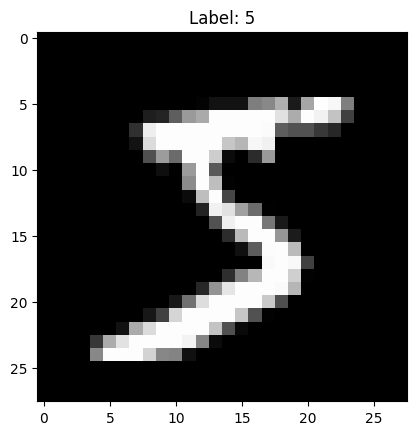

In [ ]:
import matplotlib.pyplot as plt

#print((x_train[0]))
#print((y_train[0]))

# 첫 번째 학습 이미지 보기
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

딥러닝 학습은 "반복하면서 점점 더 잘해지는 과정"이다!

컴퓨터(CNN 모델)도 비슷해!
👉 처음 가중치는 랜덤으로 초기화돼 (아무것도 모름!)

👉 첫 번째 epoch 때는 → 조금 엉성하게 학습함

👉 반복하면서 → 조금씩 더 정확하게 "패턴"을 학습함

👉 epoch 수가 늘어날수록 → 오차(Loss)가 줄어들고 정확도(Accuracy)가 올라감

1️⃣ epochs를 너무 많이 돌리면 왜 오히려 나빠질 수도 있는지 (Overfitting)

2️⃣ epochs를 몇 번으로 설정하는 기준은 뭔지

3️⃣ 학습 곡선(Loss, Accuracy 그래프) 직접 그려보는 코드 예시

In [ ]:
# hyper-parameter 설정
batch_size = 100 # 한 번에 100장씩 학습하겠다!
epochs = 20 # 전체 데이터를 20번 반복해서 학습하겠다!

to_categorical() 는 정수형 라벨 → One-hot 벡터로 바꿔주는 것(정수 아니면 불가)

👉 "정수 하나 → 10개짜리 벡터로 바꿔주는 것"

예시:

원래 y_train 값	to_categorical 결과 (one-hot encoding)

0	[1 0 0 0 0 0 0 0 0 0]

1	[0 1 0 0 0 0 0 0 0 0]

5	[0 0 0 0 0 1 0 0 0 0]

9	[0 0 0 0 0 0 0 0 0 1]

Dense(10, activation='softmax')

👉 softmax는 → 10개의 확률(0~1)을 출력해!


[0.01  0.02  0.00  0.00  0.05  0.90  0.00  0.00  0.02  0.00]

→ "가장 확률 높은 게 5니까 → 숫자 5로 예측"


✅ 모델 출력은 → 10개짜리 확률 벡터
✅ 근데 y_train 은 → 그냥 숫자 하나 (예: 5)

👉 이 둘이 비교가 안 맞아!
👉 그래서 y_train도 10개짜리 벡터로 바꿔줘야 비교가 가능!

그럼 to_categorical 의 전제조건이 뭐냐?

👉 입력값은 반드시 "0 이상 정수(int)"여야 해!

| 예                    | 가능?            |
| -------------------- | -------------- |
| `0, 1, 2, 3, 4, ...` | 가능 ✅           |
| `5, 7, 9, 0, 2`      | 가능 ✅           |
| `-1, -3`             | 불가능 ❌ (음수 안 됨) |
| `3.5, 2.7` (소수)      | 불가능 ❌          |
| `'cat', 'dog'` (문자)  | 불가능 ❌          |


In [ ]:
# 정규화
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

(60000, 10)
(10000, 10)


(60000, 10)

(10000, 10)

| 차원    | 의미                                         |
| ----- | ------------------------------------------ |
| 60000 | 데이터 개수 → **이미지 개수(학습용 60000장)**            |
| 10    | 클래스 개수(0\~9) → **One-hot 인코딩으로 변환된 벡터 길이** |

In [ ]:
print(y_train.shape)
print(y_test.shape)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


입력 이미지 (28x28x1) → Conv2D → Pooling → Conv2D → Pooling → Flatten → (나중에 Dense로 분류)

지금은 이미지 특징(Feature) 를 점점 뽑아내고 있는 단계야.

1️⃣ model = Sequential()

👉 "나는 레이어들을 순서대로 쌓는 모델을 만들 거야!" 선언하는 것.

→ 그냥 CNN 기본 모델은 거의 다 Sequential로 시작해.

2️⃣ 첫 번째 Conv2D

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 activation='relu', input_shape=(28, 28, 1)))

👉 "28x28 흑백 이미지(1 채널)를 받아서,

👉 3x3 크기의 필터(커널)를 사용해서 특징을 뽑겠다

👉 필터 32개 사용 → 결과는 32개의 특징 맵 생성

👉 'same' → 출력 크기 유지 (28x28)

👉 activation='relu' → 비선형성 추가 (복잡한 패턴 학습)"

쉽게 비유 🚀

👉 "사진(이미지)를 확대경으로 훑으면서 → 특징(선, 모서리, 점 등)을 찾아낸다!"

필터 32개 → 32가지 특징을 서로 다르게 뽑음.

3️⃣ 첫 번째 MaxPooling

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

👉 "이미지 크기를 절반으로 줄이겠다 → 28x28 → 14x14로 줄어듦"

👉 이유: 계산량 줄이고 중요한 정보만 남기기

👉 pool_size = (2,2) → 2x2 영역에서 "가장 큰 값만 남김" (MaxPooling)

쉽게 비유 🚀

👉 "이미지 요약하기!"

👉 "덜 중요한 디테일은 버리고, 핵심 정보만 압축!"

4️⃣ 두 번째 Conv2D

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

👉 다시 한 번 3x3 필터로 특징 뽑기

👉 이번엔 64개 필터 사용 → 더 복잡한 특징 학습

👉 입력 크기 → (14x14) 였다가 여전히 (14x14), 채널만 64개로 증가

5️⃣ 두 번째 MaxPooling

model.add(MaxPooling2D(pool_size=(2, 2)))

👉 다시 크기 줄이기 → (14x14) → (7x7) 로 축소

6️⃣ Flatten

model.add(Flatten())

✅ 가장 중요한 부분!

👉 CNN은 지금까지 이미지를 특징 맵으로 변환했어 → (7,7,64) 형태임

👉 근데 Dense(완전연결층)에 넣으려면 → 1차원 벡터로 바꿔야 해!

👉 Flatten → 3차원 배열 → 1차원 벡터로 "펴주는 것"

| 레이어                             | 출력 shape 변화              | 설명                  |
| ------------------------------- | ------------------------ | ------------------- |
| 입력                              | (28, 28, 1)              | 흑백 이미지 28x28        |
| Conv2D(32, 3x3, padding='same') | (28, 28, 32)             | 필터 32개 → 채널 32개로 증가 |
| MaxPooling2D(2x2)               | (14, 14, 32)             | 크기 절반으로 축소          |
| Conv2D(64, 3x3, padding='same') | (14, 14, 64)             | 필터 64개 → 채널 64개로 증가 |
| MaxPooling2D(2x2)               | (7, 7, 64)               | 크기 절반으로 축소          |
| Flatten()                       | (7 \* 7 \* 64) → (3136,) | 1차원 벡터로 변환          |


model.add(Dense(128, activation='relu'))

✅ Dense layer (완전 연결층)

→ Flatten() 으로 펴준 벡터(1차원 3136개)를 받아서 → 128개의 뉴런으로 연결

역할:

👉 CNN이 뽑아준 "이미지 특징"을 조합해서 더 고차원적인 패턴을 학습

👉 "숫자 5는 이런 특징이 조합되면 나오네?" 를 배우는 단계

activation='relu'`:

👉 각 뉴런이 비선형 변환해서 복잡한 패턴 학습 가능하게 함.

요약:
3136 → 128개의 뉴런으로 변환 → 패턴 더 잘 이해하기

model.add(Dropout(0.5))

✅ Dropout → 과적합 방지용 레이어

Dropout(0.5):

👉 학습할 때 → 무작위로 뉴런의 50%를 꺼버린다!

왜?

👉 Dense 층은 너무 많은 파라미터가 있어서 잘 외워버림 (overfitting)!

👉 Dropout을 하면 → "너무 외우지 말고 다양한 패턴을 배우게" 강제로 유도.

요약:
Dense(128)를 학습할 때 → 절반 뉴런 꺼서 과적합 방지!

model.add(Dense(10, activation='softmax'))

✅ 최종 출력층!

✅ Dense(10) → 10개 뉴런 → 숫자 0~9 중 어떤 숫자인지 확률로 예측

softmax activation:

👉 출력값을 0~1 사이 확률로 변환하고, 전체 합이 1이 되게 함

👉 즉, "이 숫자가 0일 확률", "1일 확률", ..., "9일 확률" 출력!

[0.01  0.02  0.00  0.00  0.05  0.90  0.00  0.00  0.02  0.00]

In [ ]:
# CNN의 설정
model = Sequential()

# conv2 : 특징추출 학
# 첫 conv2에는 입력 데이터 모양을 알려줘야해서 input_shape=(28, 28, 1) 필요.
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                 activation='relu', input_shape=(28, 28, 1)))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#두번째 conv2d 는 keras가 첫번째 conv 에 셋팅된값 자동으로 갔다씀. strides=(1, 1) 는 디폴트값이 내부적으로 적용됨
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())

# "이 특징 조합이 숫자 5인지, 숫자 3인지"를 결정하는 건 → Dense가 학습하는 부분이야!
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습시키기
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    batch_size=batch_size, epochs=epochs, verbose=1)


Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7268 - loss: 2.3285 - val_accuracy: 0.9761 - val_loss: 0.0853
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9498 - loss: 0.1693 - val_accuracy: 0.9821 - val_loss: 0.0614
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9656 - loss: 0.1203 - val_accuracy: 0.9878 - val_loss: 0.0445
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9730 - loss: 0.0905 - val_accuracy: 0.9877 - val_loss: 0.0462
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9755 - loss: 0.0832 - val_accuracy: 0.9866 - val_loss: 0.0469
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9794 - loss: 0.0688 - val_accuracy: 0.9873 - val_loss: 0.0441
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9810 - loss: 0.0627 - val_accuracy: 0.9893 - val_loss: 0.0419
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9811 - loss: 0.0616 - val_accuracy: 0.

In [ ]:
# 정확도와 손실함수 그래프
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


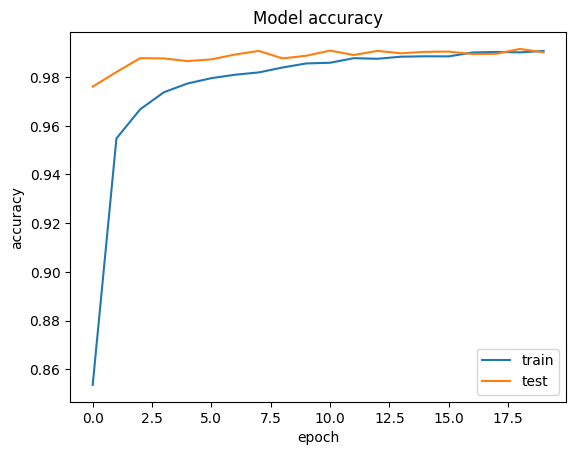

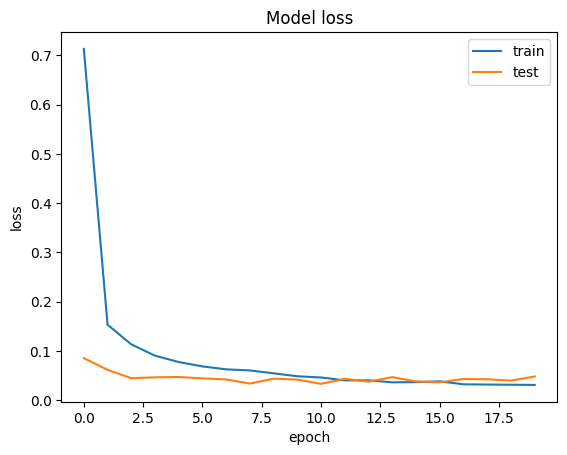

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()